# Convolutional Neural Networks Using Transfer Learning

In [ ]:
!pip install gdown tensorflow keras matplotlib
import gdown

url = "https://drive.google.com/uc?id=1ur8V2VAx5G7Eb33ZtigfUxWK4Nf_GO0V"
output = "monkey_species.zip"
gdown.download(url, output, quiet=False)
!unzip -q monkey_species.zip -d monkey_species_data
!ls monkey_species_data


Downloading...
From (original): https://drive.google.com/uc?id=1ur8V2VAx5G7Eb33ZtigfUxWK4Nf_GO0V
From (redirected): https://drive.google.com/uc?id=1ur8V2VAx5G7Eb33ZtigfUxWK4Nf_GO0V&confirm=t&uuid=d19a5573-c0cc-466f-9f5e-10b141582de5
To: /content/monkey_species.zip
100%|██████████| 574M/574M [00:10<00:00, 53.4MB/s]


archive-2  __MACOSX


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
learning_rate = 0.0001
dropout_rate = 0.5
batch_size = 32
epochs = 10
optimizer_name = 'Adam'  # choose: 'Adam' or 'RMSprop'

print(f"Training model with:\n"
      f"Learning rate = {learning_rate}\n"
      f"Dropout = {dropout_rate}\n"
      f"Batch size = {batch_size}\n"
      f"Epochs = {epochs}\n"
      f"Optimizer = {optimizer_name}")

Training model with:
Learning rate = 0.0001
Dropout = 0.5
Batch size = 32
Epochs = 10
Optimizer = Adam


In [ ]:
train_dir = "monkey_species_data/archive-2/training/training"
val_dir = "monkey_species_data/archive-2/validation/validation"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze feature extractor

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

if optimizer_name == 'Adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = RMSprop(learning_rate=learning_rate)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# creating an empty list to log parameter tuning results
tuning_results = []


In [ ]:
# training the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1370 - loss: 2.5632 - val_accuracy: 0.4375 - val_loss: 1.8207
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 856ms/step - accuracy: 0.3649 - loss: 1.8737 - val_accuracy: 0.7574 - val_loss: 1.3460
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 877ms/step - accuracy: 0.5826 - loss: 1.4413 - val_accuracy: 0.8750 - val_loss: 0.9682
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 857ms/step - accuracy: 0.7168 - loss: 1.0854 - val_accuracy: 0.9118 - val_loss: 0.7002
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 925ms/step - accuracy: 0.7814 - loss: 0.8563 - val_accuracy: 0.9228 - val_loss: 0.5292
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 954ms/step - accuracy: 0.8235 - loss: 0.6905 - val_accuracy: 0.9375 - val_loss: 0.4033
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 900ms/step - accuracy: 0.8702 - loss: 0.5423 - val_accuracy: 0.9375 - val_loss: 0.3280
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 856ms/step - accuracy: 0.8723 - loss: 0.4832 - val_accurac

Experiment 1

In [ ]:
# parameters
learning_rate = 0.001
dropout_rate = 0.5
dense_units = 256
optimizer_name = 'Adam'
epochs = 5

# base model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # keeping frozen for transfer learning

# building model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

# choosing optimizer
if optimizer_name == 'Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# compiling the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# training the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1
)

# logging results
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

tuning_results.append({
    'Experiment': 1,
    'Learning Rate': learning_rate,
    'Dropout': dropout_rate,
    'Dense Units': dense_units,
    'Optimizer': optimizer_name,
    'Epochs': epochs,
    'Training Accuracy (%)': round(train_acc, 2),
    'Validation Accuracy (%)': round(val_acc, 2)
})


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4805 - loss: 7.1271 - val_accuracy: 0.9154 - val_loss: 0.4344
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 856ms/step - accuracy: 0.8081 - loss: 0.8952 - val_accuracy: 0.9338 - val_loss: 0.3397
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 881ms/step - accuracy: 0.8864 - loss: 0.4550 - val_accuracy: 0.9412 - val_loss: 0.2689
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 862ms/step - accuracy: 0.9030 - loss: 0.3633 - val_accuracy: 0.9559 - val_loss: 0.2342
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 856ms/step - accuracy: 0.9153 - loss: 0.3411 - val_accuracy: 0.9522 - val_loss: 0.2349


Experiment 2: lowering LR

In [ ]:
learning_rate = 0.0005      # ↓ from 0.001
dropout_rate = 0.5
dense_units = 256
optimizer_name = 'Adam'
epochs = 5

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=epochs, verbose=1)

train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

tuning_results.append({
    'Experiment': len(tuning_results) + 1,
    'Learning Rate': learning_rate,
    'Dropout': dropout_rate,
    'Batch Size': 32,
    'Dense Units': dense_units,
    'Optimizer': optimizer_name,
    'Epochs': epochs,
    'Training Accuracy (%)': round(train_acc, 2),
    'Validation Accuracy (%)': round(val_acc, 2)
})


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4989 - loss: 4.3399 - val_accuracy: 0.9449 - val_loss: 0.2453
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 854ms/step - accuracy: 0.8793 - loss: 0.4087 - val_accuracy: 0.9449 - val_loss: 0.2249
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 883ms/step - accuracy: 0.9194 - loss: 0.2744 - val_accuracy: 0.9743 - val_loss: 0.1505
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 857ms/step - accuracy: 0.9346 - loss: 0.2163 - val_accuracy: 0.9632 - val_loss: 0.1697
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 845ms/step - accuracy: 0.9208 - loss: 0.2682 - val_accuracy: 0.9485 - val_loss: 0.3364


Experiment 3: increasing dropout

In [ ]:
learning_rate = 0.0005     # (best so far)
dropout_rate = 0.6         # increase dropout for stronger regularization
dense_units = 256
optimizer_name = 'Adam'
epochs = 5

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data, epochs=epochs, verbose=1)

train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

tuning_results.append({
    'Experiment': len(tuning_results) + 1,
    'Learning Rate': learning_rate,
    'Dropout': dropout_rate,
    'Batch Size': 32,
    'Dense Units': dense_units,
    'Optimizer': optimizer_name,
    'Epochs': epochs,
    'Training Accuracy (%)': round(train_acc, 2),
    'Validation Accuracy (%)': round(val_acc, 2)
})


NameError: name 'tf' is not defined

In [ ]:
# logging the results
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
tuning_results.append({
    'Experiment': len(tuning_results) + 1,
    'Learning Rate': learning_rate,
    'Dropout': dropout_rate,
    'Batch Size': 32,   # keep fixed value if not changing
    'Dense Units': dense_units,
    'Optimizer': optimizer_name,
    'Epochs': epochs,
    'Training Accuracy (%)': round(train_acc, 2),
    'Validation Accuracy (%)': round(val_acc, 2)
})

In [ ]:
# showing the tuning results
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)

,Experiment,Learning Rate,Dropout,Batch Size,Dense Units,Optimizer,Epochs,Training Accuracy (%),Validation Accuracy (%)
0,1,0.0005,0.6,32,256,Adam,5,90.53,95.22


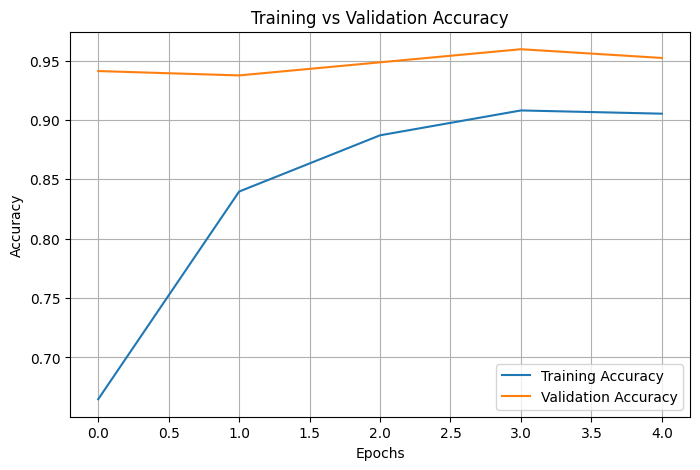

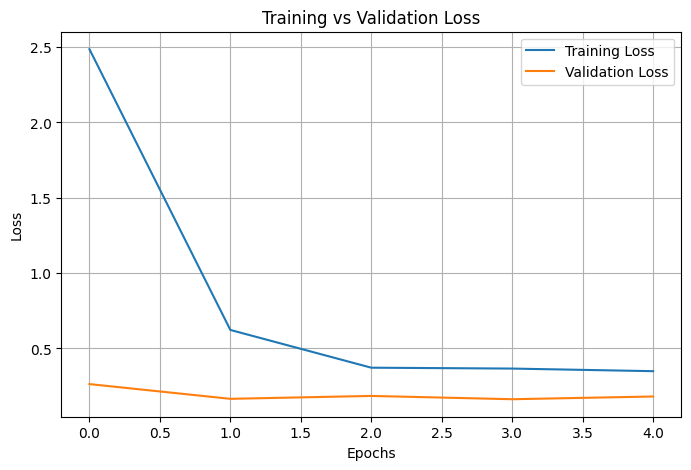

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


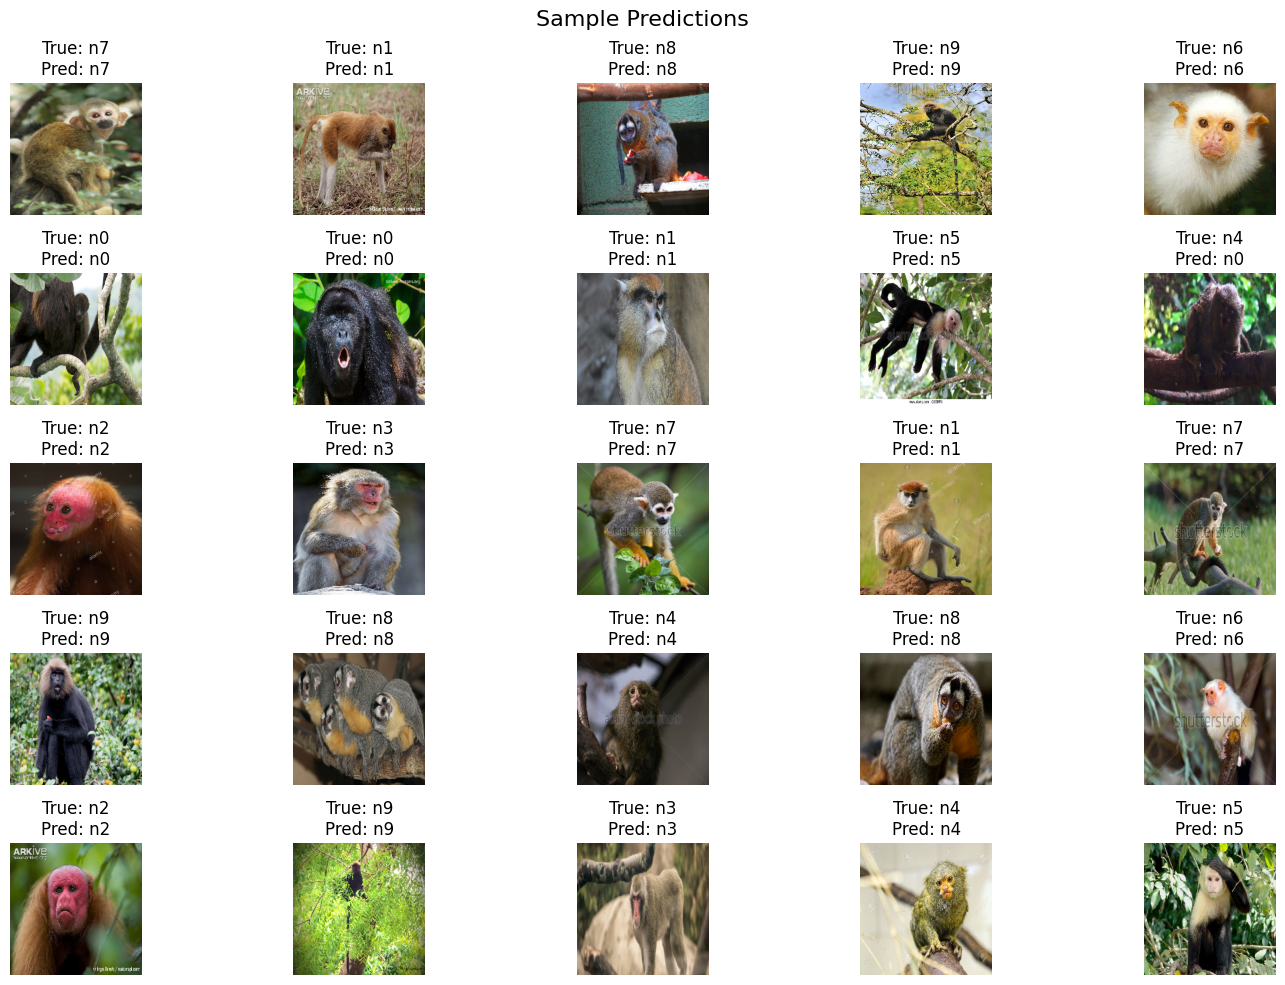

In [ ]:
import random
class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15,10))
plt.suptitle("Sample Predictions", fontsize=16) # Use suptitle for overall title

for i in range(25):
    img, label = next(val_data) # Use next() to get the next batch
    idx = random.randint(0, len(img)-1)
    prediction = model.predict(np.expand_dims(img[idx], axis=0))
    pred_class = class_names[np.argmax(prediction)]
    true_class = class_names[np.argmax(label[idx])]

    plt.subplot(5,5,i+1)
    plt.imshow(img[idx])
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()